In [1]:
import sys

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../RD-systems-and-test-benches/utils")
import model_fsolve as modf
import model_fsolve_v2 as modf2

import scipy.optimize as sco
import scipy.interpolate as sci

import hx_hydraulic as hxhy
import from_excel as fe
import data_plots as dplt

import fluids as fds
from CoolProp.CoolProp import PropsSI

import openpyxl as opxl
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import os
import plotly.graph_objects as go

import copy

import utils.conversion as conv

In [2]:
df_V45 = pd.read_excel(r'G:\Drive partagés\Cercle Hard\R&D\Thèse VDE\Manuscrit\Chapter_PL\TUV_PL_results_V4.5_V4.6.xlsx', sheet_name = "V4.5_water")
# df_V46 = pd.read_excel(r'G:\Drive partagés\Cercle Hard\R&D\Thèse VDE\Manuscrit\Chapter_PL\TUV_PL_results_V4.5_V4.6.xlsx', sheet_name = "V4.6_glycol")

df_V45['Q'] = df_V45['Vdot'].apply(lambda x: conv.convert_flow_rate(x, 'L/h', 'm3/s'))
df_V45 = df_V45.loc[df_V45['Vdot'] > 0]
df_V45.sort_values(by = 'Vdot', inplace = True)
df_V45.reset_index(drop = True, inplace = True)

In [3]:
path = r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Inputs"
file_name = "\V4.5.xlsx"
hw, par, cond = fe.initialize(path, file_name)

fluid = {'name':'water','glycol_rate':0.}
T_op = 23
p = 1

rho_op = PropsSI('D', 'T', conv.to_K(T_op), 'P', 1e5, hxhy.find_fluid(fluid))
mu_op = PropsSI('V', 'T', conv.to_K(T_op), 'P', 1e5, hxhy.find_fluid(fluid))

fe.change_fluid(cond, fluid)
fe.change_temperature(cond, conv.to_K(T_op), fluid)

# tabl, res, PL, residuals = modf.PL_fsolve(par, cond) 

In [4]:
D_tuy = 38.5e-3
A_tuy = math.pi * (D_tuy/2)**2
D_fit = 15e-3
A_fit = math.pi * (D_fit/2)**2
D_man = 18e-3
A_man = math.pi * (D_man/2)**2

In [5]:
df_V45['first_contraction'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.contraction_sharp(Di1=D_tuy, Di2=D_fit, Re = fds.core.Reynolds(V=x/A_tuy, D=D_tuy, rho = rho_op, mu = mu_op)),
                                                                          rho = rho_op,
                                                                          V = x/A_tuy))

df_V45['bend_in_fitting'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K=fds.fittings.bend_rounded(Di=D_fit, angle=90, rc = 40e-3, Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op),L_unimpeded=50e-3),
                                                                       rho = rho_op,
                                                                       V = x/A_fit))

df_V45['linear_after_bend'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.K_from_f(fds.friction.friction_factor(Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op)), L=55e-3, D=D_fit),
                                                                                rho = rho_op,
                                                                                V = x/A_fit))

df_V45['first_expansion'] = df_V45['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.contraction_sharp(Di1=D_fit, Di2=D_man, Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op)),
                                                                          rho = rho_op,
                                                                          V = x/A_fit))

df_V45['before_hx'] = df_V45['first_contraction'] + df_V45['bend_in_fitting'] + df_V45['linear_after_bend'] + df_V45['first_expansion']

df_V45['both_singular'] = 2*df_V45['before_hx']
df_V45['singular_proportion'] = df_V45['both_singular'] / df_V45['PL']

In [6]:
res_dict = {}
PL_res = []

for Vdot in df_V45['Vdot']:
    fe.change_Vdot(cond, Vdot)
    tabl, PL, df_PL, residuals = modf.PL_fsolve(par, cond)

    res_dict[Vdot] = {'tabl' : copy.deepcopy(tabl),
                      'PL' : PL,
                      'df_PL' : copy.deepcopy(df_PL),
                      'residuals' : copy.deepcopy(residuals)}

    PL_res.append(PL)

In [7]:
df_V45['PL_hx_model'] = np.array(PL_res)/1000

In [8]:
df_V45['PL_tot_model'] = df_V45['PL_hx_model'] + df_V45['both_singular']

In [9]:
df_V45

,Vdot,mdot,PL,Q,first_contraction,bend_in_fitting,linear_after_bend,first_expansion,before_hx,both_singular,singular_proportion,PL_hx_model,PL_tot_model
0,84.0,84.0,0.33,0.000023,0.000107,0.003705,0.001547,0.005325,0.010684,0.021368,0.064752,0.123755,0.145123
1,89.3,89.1,0.39,0.000025,0.000121,0.004120,0.001715,0.006018,0.011973,0.023946,0.061401,0.131743,0.155690
2,173.0,173.0,0.85,0.000048,0.000453,0.013113,0.005260,0.022585,0.041411,0.082822,0.097437,0.262668,0.345489
3,176.0,176.0,0.92,0.000049,0.000469,0.013517,0.005417,0.023375,0.042778,0.085556,0.092995,0.267512,0.353067
4,263.0,262.0,1.55,0.000073,0.001046,0.027573,0.010788,0.052196,0.091604,0.183208,0.118198,0.411415,0.594622
5,276.0,275.0,1.63,0.000077,0.001152,0.030051,0.011724,0.057484,0.100411,0.200821,0.123203,0.433608,0.634430
6,314.0,313.0,1.99,0.000087,0.001492,0.037843,0.014647,0.074402,0.128383,0.256766,0.129028,0.499539,0.756305
7,321.0,320.0,2.04,0.000089,0.001559,0.039366,0.015216,0.077756,0.133897,0.267793,0.131271,0.511862,0.779655
8,396.0,395.0,2.78,0.000110,0.002372,0.057379,0.021889,0.118336,0.199975,0.399951,0.143867,0.647361,1.047312
9,396.0,395.0,2.82,0.000110,0.002372,0.057379,0.021889,0.118336,0.199975,0.399951,0.141827,0.647361,1.047312


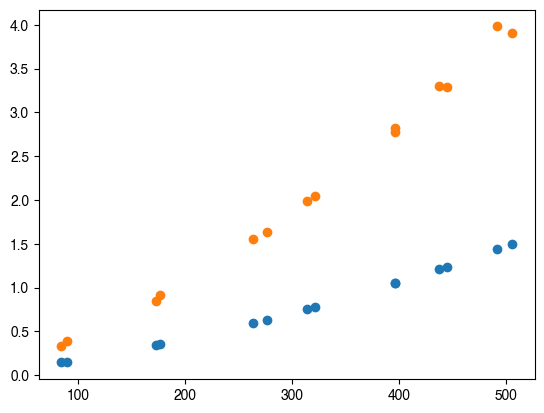

In [10]:
plt.scatter(df_V45['Vdot'], df_V45['PL_tot_model'])
plt.scatter(df_V45['Vdot'], df_V45['PL'])